In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler

from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
import xgboost as xgb

In [3]:
df = pd.read_csv("Loan_Default.csv")
df.head()

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,...,EXP,758,CIB,25-34,to_inst,98.728814,south,direct,1,45.0
1,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,...,EQUI,552,EXP,55-64,to_inst,NaN,North,direct,1,NaN
2,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,...,EXP,834,CIB,35-44,to_inst,80.019685,south,direct,0,46.0
3,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,EXP,587,CIB,45-54,not_inst,69.376900,North,direct,0,42.0
4,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,CRIF,602,EXP,25-34,not_inst,91.886544,North,direct,0,39.0


In [4]:
df.shape

(148670, 34)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   ID                         148670 non-null  int64  
 1   year                       148670 non-null  int64  
 2   loan_limit                 145326 non-null  object 
 3   Gender                     148670 non-null  object 
 4   approv_in_adv              147762 non-null  object 
 5   loan_type                  148670 non-null  object 
 6   loan_purpose               148536 non-null  object 
 7   Credit_Worthiness          148670 non-null  object 
 8   open_credit                148670 non-null  object 
 9   business_or_commercial     148670 non-null  object 
 10  loan_amount                148670 non-null  int64  
 11  rate_of_interest           112231 non-null  float64
 12  Interest_rate_spread       112031 non-null  float64
 13  Upfront_charges            10

In [6]:
df.describe()

,ID,year,loan_amount,rate_of_interest,Interest_rate_spread,Upfront_charges,term,property_value,income,Credit_Score,LTV,Status,dtir1
count,148670.000000,148670.0,1.486700e+05,112231.000000,112031.000000,109028.000000,148629.000000,1.335720e+05,139520.000000,148670.000000,133572.000000,148670.000000,124549.000000
mean,99224.500000,2019.0,3.311177e+05,4.045476,0.441656,3224.996127,335.136582,4.978935e+05,6957.338876,699.789103,72.746457,0.246445,37.732932
std,42917.476598,0.0,1.839093e+05,0.561391,0.513043,3251.121510,58.409084,3.599353e+05,6496.586382,115.875857,39.967603,0.430942,10.545435
min,24890.000000,2019.0,1.650000e+04,0.000000,-3.638000,0.000000,96.000000,8.000000e+03,0.000000,500.000000,0.967478,0.000000,5.000000
25%,62057.250000,2019.0,1.965000e+05,3.625000,0.076000,581.490000,360.000000,2.680000e+05,3720.000000,599.000000,60.474860,0.000000,31.000000
50%,99224.500000,2019.0,2.965000e+05,3.990000,0.390400,2596.450000,360.000000,4.180000e+05,5760.000000,699.000000,75.135870,0.000000,39.000000
75%,136391.750000,2019.0,4.365000e+05,4.375000,0.775400,4812.500000,360.000000,6.280000e+05,8520.000000,800.000000,86.184211,0.000000,45.000000
max,173559.000000,2019.0,3.576500e+06,8.000000,3.357000,60000.000000,360.000000,1.650800e+07,578580.000000,900.000000,7831.250000,1.000000,61.000000


In [7]:
df.replace({ '>': 'gt', '<': 'lt'}, regex=True, inplace=True)

In [8]:
df['age'].unique()

array(['25-34', '55-64', '35-44', '45-54', '65-74', 'gt74', 'lt25', nan],
      dtype=object)

In [9]:
df['Status'].unique()

array([1, 0], dtype=int64)

In [10]:
df['Status'].value_counts()

0    112031
1     36639
Name: Status, dtype: int64

<BarContainer object of 2 artists>

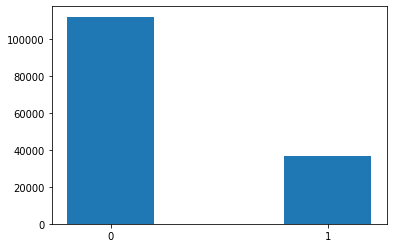

In [11]:
plt.bar(list(['0','1']), df['Status'].value_counts(), width=0.4)

In [12]:
categorical_cols = [col for col in df.columns if df[col].dtype == 'object']

In [13]:
#number of unique values for string columns
def get_category_summary(df):
    unique_values_dataframe = pd.DataFrame()
    for index, col in enumerate(categorical_cols):
        unique_values_dataframe.loc[index, 'Column'] = col
        unique_values_dataframe.loc[index, 'Number Of unique values'] = len(df[col].unique())
        unique_values_dataframe.loc[index, 'Unique values'] = ', '.join(str(val) for val in df[col].unique())
        index +=1
    return unique_values_dataframe

In [14]:
def get_missing_data_info(dataframe):
    total = dataframe.isnull().sum().sort_values(ascending=False)
    percent_1 = dataframe.isnull().sum() / dataframe.isnull().count()*100
    percent_2 = (round(percent_1,1)).sort_values(ascending=False)
    missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
    return missing_data

In [15]:
get_missing_data_info(df)

,Total,%
Upfront_charges,39642,26.7
Interest_rate_spread,36639,24.6
rate_of_interest,36439,24.5
dtir1,24121,16.2
LTV,15098,10.2
property_value,15098,10.2
income,9150,6.2
loan_limit,3344,2.2
approv_in_adv,908,0.6
submission_of_application,200,0.1


In [16]:
missing_cols = [col for col in df.columns if  df[col].isnull().sum() > 0]
missing_cols

['loan_limit',
 'approv_in_adv',
 'loan_purpose',
 'rate_of_interest',
 'Interest_rate_spread',
 'Upfront_charges',
 'term',
 'Neg_ammortization',
 'property_value',
 'income',
 'age',
 'submission_of_application',
 'LTV',
 'dtir1']

In [17]:
missing_categorical_cols = [col for col in missing_cols if df[col].dtype == 'object']
missing_categorical_cols

['loan_limit',
 'approv_in_adv',
 'loan_purpose',
 'Neg_ammortization',
 'age',
 'submission_of_application']

In [18]:
get_missing_data_info(df[missing_categorical_cols])

,Total,%
loan_limit,3344,2.2
approv_in_adv,908,0.6
age,200,0.1
submission_of_application,200,0.1
loan_purpose,134,0.1
Neg_ammortization,121,0.1


<h5>Encoding Missingness</h5>
When an attribute is discrete in nature, missingness can be directly encoded into the attribute as if it were a naturally occurring category

In [19]:
df[missing_categorical_cols] = df[missing_categorical_cols].fillna('missing')

In [20]:
get_missing_data_info(df[missing_categorical_cols])

,Total,%
loan_limit,0,0.0
approv_in_adv,0,0.0
loan_purpose,0,0.0
Neg_ammortization,0,0.0
age,0,0.0
submission_of_application,0,0.0


In [21]:
get_missing_data_info(df)

,Total,%
Upfront_charges,39642,26.7
Interest_rate_spread,36639,24.6
rate_of_interest,36439,24.5
dtir1,24121,16.2
LTV,15098,10.2
property_value,15098,10.2
income,9150,6.2
term,41,0.0
submission_of_application,0,0.0
age,0,0.0


In [22]:
missing_numeric_cols = [col for col in missing_cols if col not in missing_categorical_cols]
missing_numeric_cols

['rate_of_interest',
 'Interest_rate_spread',
 'Upfront_charges',
 'term',
 'property_value',
 'income',
 'LTV',
 'dtir1']

In [23]:
for col in missing_numeric_cols:
    df[col]= df[col].fillna(df[col].mean())

In [24]:
get_missing_data_info(df)

,Total,%
ID,0,0.0
Credit_Score,0,0.0
construction_type,0,0.0
occupancy_type,0,0.0
Secured_by,0,0.0
total_units,0,0.0
income,0,0.0
credit_type,0,0.0
co-applicant_credit_type,0,0.0
year,0,0.0


In [25]:
col=['ID','open_credit','construction_type','Secured_by','total_units']
df=df.drop(col,axis=1)

In [26]:
numeric_cols = [col for col in df.select_dtypes(exclude=['object']).columns]
scaler = MinMaxScaler()
scaler.fit(df[numeric_cols])
df[numeric_cols] = scaler.transform(df[numeric_cols])

In [27]:
encoded_data = pd.get_dummies(df, drop_first=True)
encoded_data

,year,loan_amount,rate_of_interest,Interest_rate_spread,Upfront_charges,term,property_value,income,Credit_Score,LTV,...,age_65-74,age_gt74,age_lt25,age_missing,submission_of_application_not_inst,submission_of_application_to_inst,Region_North-East,Region_central,Region_south,Security_Type_direct
0,0.0,0.028090,0.505684,0.583225,0.053750,1.000000,0.006667,0.003007,0.6450,0.012485,...,0,0,0,0,0,1,0,0,1,1
1,0.0,0.053371,0.505684,0.583225,0.053750,1.000000,0.029691,0.008607,0.1300,0.009167,...,0,0,0,0,0,1,0,0,0,1
2,0.0,0.109551,0.570000,0.548678,0.009917,1.000000,0.030303,0.016385,0.8350,0.010096,...,0,0,0,0,0,1,0,0,1,1
3,0.0,0.123596,0.531250,0.617441,0.053750,1.000000,0.039394,0.020533,0.2175,0.008737,...,0,0,0,0,1,0,0,0,0,1
4,0.0,0.191011,0.500000,0.563574,0.000000,1.000000,0.045455,0.018044,0.2550,0.011611,...,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148665,0.0,0.117978,0.390625,0.556841,0.166000,0.318182,0.036364,0.013585,0.3975,0.009045,...,0,0,0,0,0,1,0,0,1,1
148666,0.0,0.160112,0.648750,0.642230,0.000000,1.000000,0.047273,0.012341,0.1725,0.009382,...,0,0,0,0,1,0,0,0,1,1
148667,0.0,0.120787,0.390625,0.531751,0.020444,0.318182,0.043636,0.011926,0.5050,0.007709,...,0,0,0,0,1,0,0,0,0,1
148668,0.0,0.050562,0.437500,0.603345,0.072056,0.318182,0.016364,0.012341,0.5925,0.008903,...,0,0,0,0,0,1,0,0,0,1


In [28]:
X = encoded_data.drop('Status', axis=1)
Y = encoded_data['Status']


In [29]:
def print_scores(y_true, y_pred):
    print(classification_report(y_true, y_pred))
    # try:    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12,12))
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square=True, cmap='Blues_r')
    plt.xlabel("Actual values")
    plt.ylabel("Predict values")
    plt.title("Confusion Matrix ")
    plt.show()
    # except errr:
    #     print("Error due to zero y_pred")

In [30]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, stratify=Y, test_size=0.3, random_state=42)
Y_train.value_counts()

0.0    78422
1.0    25647
Name: Status, dtype: int64

In [31]:
def fit_model_and_evaluate(model, x_train, y_train, x_test=X_test, y_test=Y_test):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    print_scores(y_test, y_pred)
     

In [32]:
def use_unbalanced_handler(handler_model, x_train=X_train, y_train=Y_train):
    if handler_model != None:    
        new_x_train, new_y_train = handler_model.fit_resample(x_train,y_train)
    else:
        new_x_train, new_y_train = x_train, y_train
    lr = LogisticRegression(solver='liblinear')
    # svm = SVC()
    xgboost = xgb.XGBClassifier(objective='binary:logistic')
    rf = RandomForestClassifier()
    algos = {'Logistic Regression': lr, 'XGBoost': xgboost, 'Random Forest': rf}
    for algo in algos:
        print(f'=================={algo}===================')
        fit_model_and_evaluate(algos[algo], new_x_train, new_y_train)
    

===================Non handle for inbalanced data =============
==================Logistic Regression===================
              precision    recall  f1-score   support

         0.0       0.86      0.99      0.92     33609
         1.0       0.95      0.49      0.64     10992

    accuracy                           0.87     44601
   macro avg       0.90      0.74      0.78     44601
weighted avg       0.88      0.87      0.85     44601



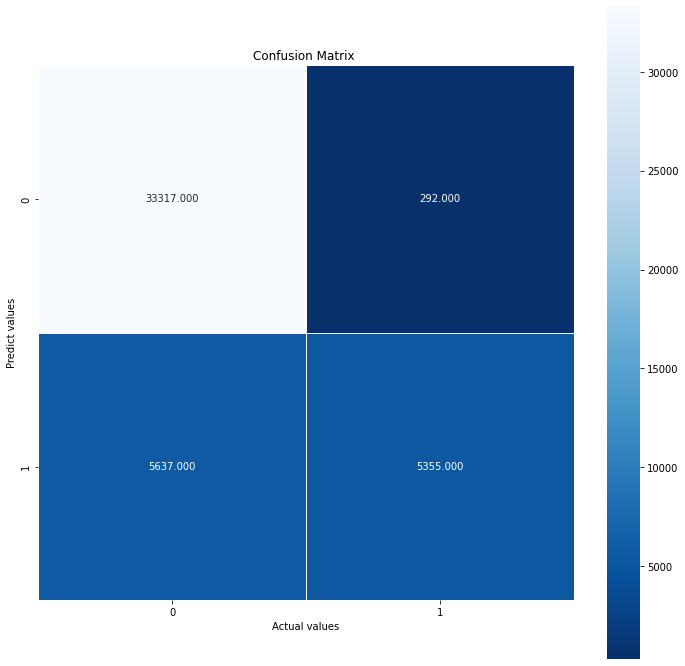

==================XGBoost===================
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     33609
         1.0       1.00      1.00      1.00     10992

    accuracy                           1.00     44601
   macro avg       1.00      1.00      1.00     44601
weighted avg       1.00      1.00      1.00     44601



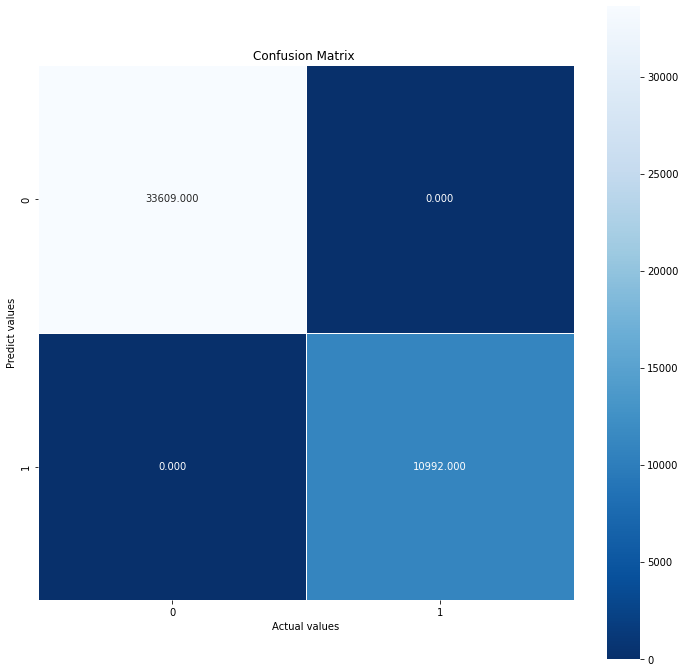

==================Random Forest===================
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     33609
         1.0       1.00      1.00      1.00     10992

    accuracy                           1.00     44601
   macro avg       1.00      1.00      1.00     44601
weighted avg       1.00      1.00      1.00     44601



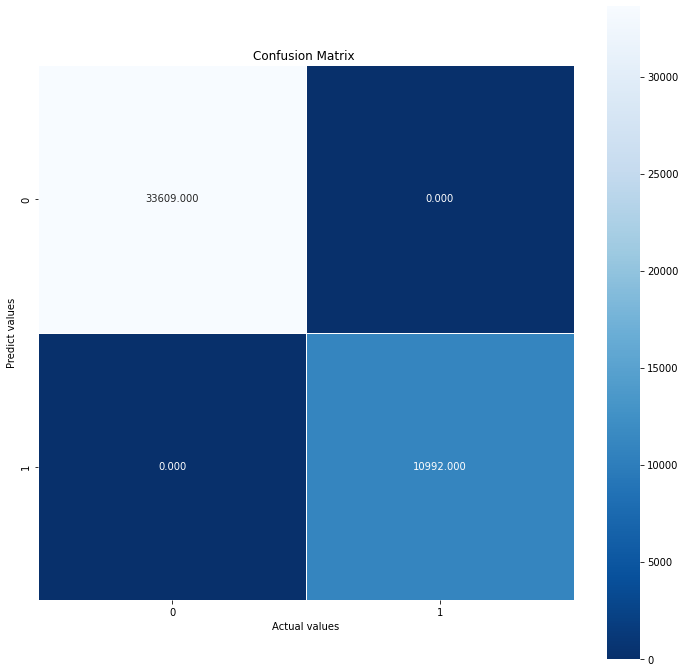

===================Using SMOTE algorithms for inbalanced data =============
==================Logistic Regression===================
              precision    recall  f1-score   support

         0.0       0.88      0.89      0.89     33609
         1.0       0.66      0.64      0.65     10992

    accuracy                           0.83     44601
   macro avg       0.77      0.77      0.77     44601
weighted avg       0.83      0.83      0.83     44601



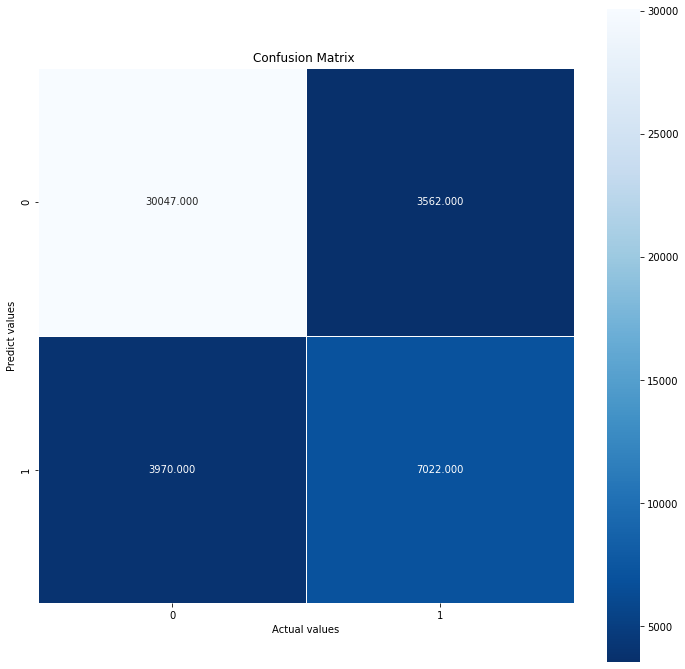

==================XGBoost===================
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     33609
         1.0       1.00      1.00      1.00     10992

    accuracy                           1.00     44601
   macro avg       1.00      1.00      1.00     44601
weighted avg       1.00      1.00      1.00     44601



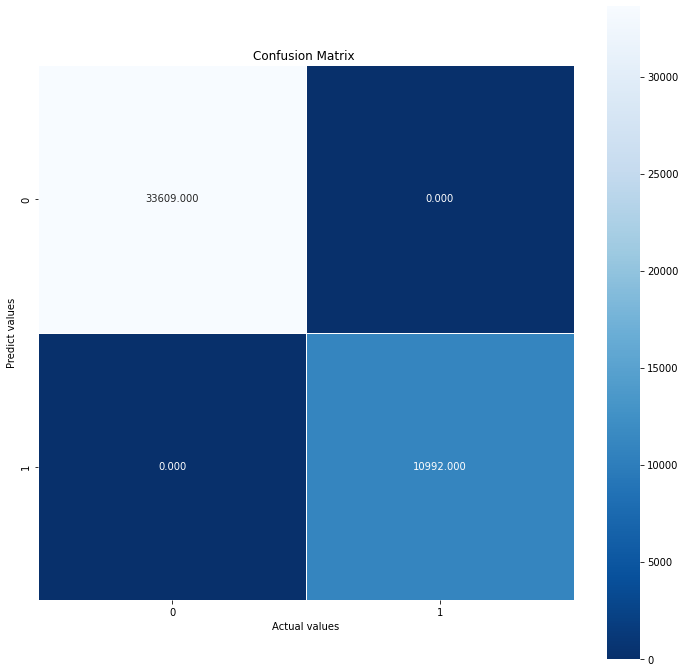

==================Random Forest===================
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     33609
         1.0       1.00      1.00      1.00     10992

    accuracy                           1.00     44601
   macro avg       1.00      1.00      1.00     44601
weighted avg       1.00      1.00      1.00     44601



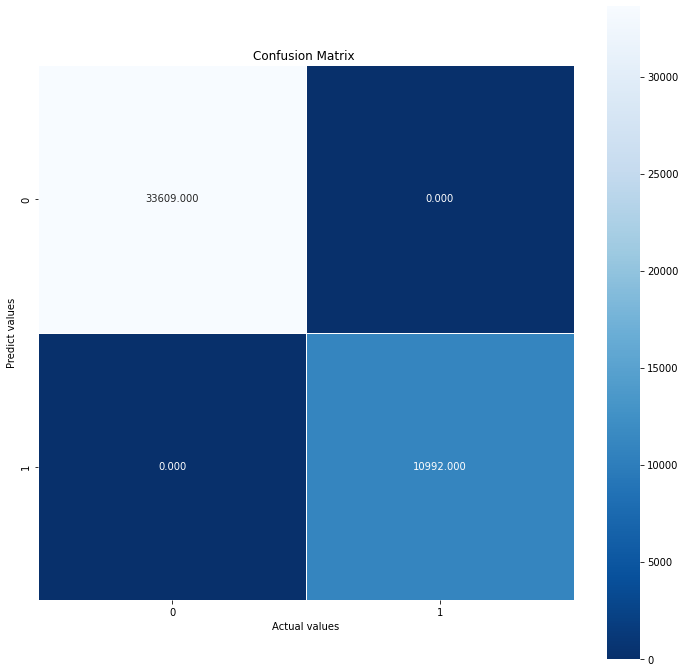

===================Using NearMiss algorithms for inbalanced data =============
==================Logistic Regression===================
              precision    recall  f1-score   support

         0.0       0.89      0.56      0.69     33609
         1.0       0.37      0.78      0.50     10992

    accuracy                           0.61     44601
   macro avg       0.63      0.67      0.59     44601
weighted avg       0.76      0.61      0.64     44601



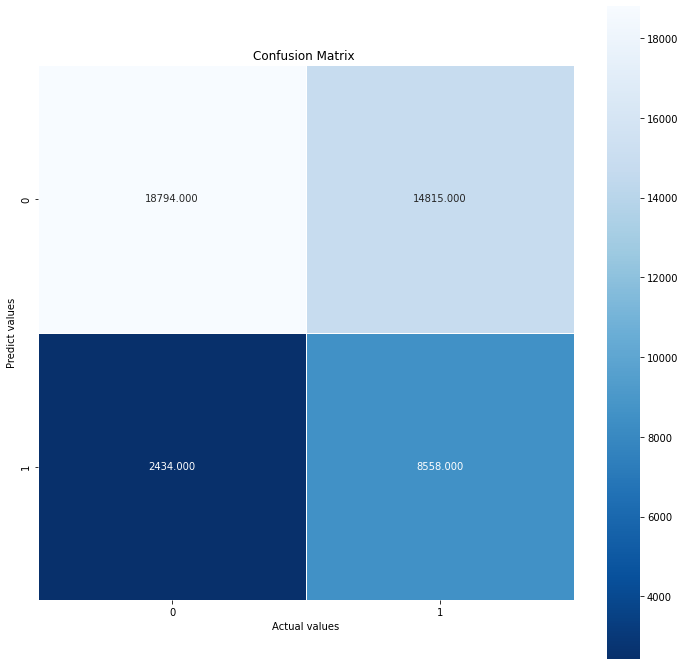

==================XGBoost===================
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     33609
         1.0       1.00      1.00      1.00     10992

    accuracy                           1.00     44601
   macro avg       1.00      1.00      1.00     44601
weighted avg       1.00      1.00      1.00     44601



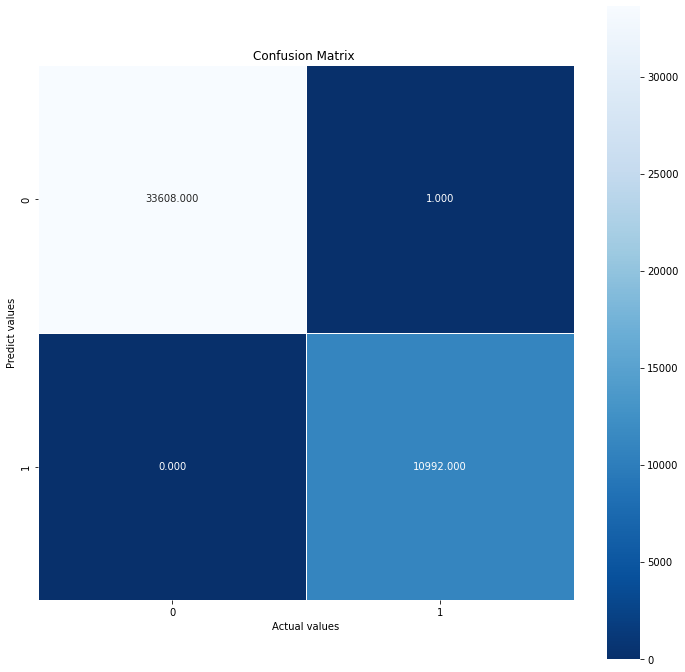

==================Random Forest===================
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     33609
         1.0       1.00      1.00      1.00     10992

    accuracy                           1.00     44601
   macro avg       1.00      1.00      1.00     44601
weighted avg       1.00      1.00      1.00     44601



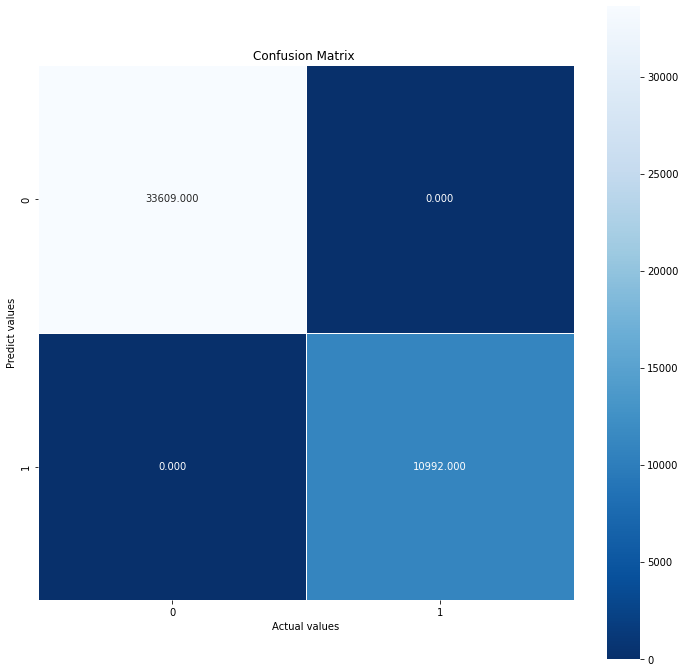

In [33]:
print('===================Non handle for inbalanced data =============')
use_unbalanced_handler(None, X_train, Y_train)
print('===================Using SMOTE algorithms for inbalanced data =============')
use_unbalanced_handler(SMOTE(), X_train, Y_train)
print('===================Using NearMiss algorithms for inbalanced data =============')
use_unbalanced_handler(NearMiss(), X_train, Y_train)
